In [21]:
import pandas as pd
import os

# List of CSV files to process
base_path = r'C:\Users\willi\CAN_experiments\\'
csv_files = [
    'performance_metrics_correlated_signal.csv',
    'performance_metrics_max_speedometer.csv',
    'performance_metrics_reverse_light_off.csv',
    'performance_metrics_reverse_light_on.csv',
    'performance_metrics_max_engine_coolant.csv'
]

# Initialize a dictionary to store the data
all_data = {}

# Iterate over each file and load the data
for file in csv_files:
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path)
    attack_type = file.replace('performance_metrics_', '').replace('.csv', '')
    
    # Store the DataFrame in the dictionary
    all_data[attack_type] = df


In [22]:
from scipy.stats import mannwhitneyu, ks_2samp
import numpy as np

# Initialize dictionaries to store the test results
mannwhitneyu_results = {}
ks_results = {}

# Perform the tests for each attack type
for attack_type, df in all_data.items():
    embeddings_only = df[df['version'] == 'embeddings_only']['roc_auc']
    normalized = df[df['version'] == 'normalized']['roc_auc']
    
    # Mann-Whitney U test with alternative='greater'
    u_statistic, p_value_u = mannwhitneyu(normalized, embeddings_only, alternative='greater')
    mannwhitneyu_results[attack_type] = {'U Statistic': u_statistic, 'P Value': p_value_u}
    
    # Two-sided Kolmogorov-Smirnov test
    ks_statistic, p_value_ks_two_sided = ks_2samp(normalized, embeddings_only)
    
    # Convert to one-sided p-value
    p_value_ks_one_sided = p_value_ks_two_sided / 2 if np.mean(normalized) > np.mean(embeddings_only) else 1 - p_value_ks_two_sided / 2
    
    ks_results[attack_type] = {'KS Statistic': ks_statistic, 'P Value': p_value_ks_one_sided}

# Print the results
for attack_type in mannwhitneyu_results:
    print(f"\nResults for '{attack_type}' attack type:")
    print(f"Mann-Whitney U Test - U Statistic: {mannwhitneyu_results[attack_type]['U Statistic']}, P Value: {mannwhitneyu_results[attack_type]['P Value']}")
    print(f"One-sided Kolmogorov-Smirnov Test - KS Statistic: {ks_results[attack_type]['KS Statistic']}, P Value: {ks_results[attack_type]['P Value']}")


Results for 'correlated_signal' attack type:
Mann-Whitney U Test - U Statistic: 11337.0, P Value: 5.554342616225123e-16
One-sided Kolmogorov-Smirnov Test - KS Statistic: 0.46218487394957986, P Value: 3.811591953613999e-12

Results for 'max_speedometer' attack type:
Mann-Whitney U Test - U Statistic: 10082.0, P Value: 7.984675509937762e-09
One-sided Kolmogorov-Smirnov Test - KS Statistic: 0.3277310924369748, P Value: 2.342924782243384e-06

Results for 'reverse_light_off' attack type:
Mann-Whitney U Test - U Statistic: 11033.0, P Value: 4.9766695538893794e-14
One-sided Kolmogorov-Smirnov Test - KS Statistic: 0.42857142857142855, P Value: 1.726574420948475e-10

Results for 'reverse_light_on' attack type:
Mann-Whitney U Test - U Statistic: 10818.0, P Value: 9.843705352094683e-13
One-sided Kolmogorov-Smirnov Test - KS Statistic: 0.42857142857142855, P Value: 1.726574420948475e-10

Results for 'max_engine_coolant' attack type:
Mann-Whitney U Test - U Statistic: 9864.0, P Value: 8.0148616068

In [23]:
# Check sample sizes for each attack type
for attack_type, df in all_data.items():
    embeddings_only = df[df['version'] == 'embeddings_only']['roc_auc']
    normalized = df[df['version'] == 'normalized']['roc_auc']
    
    sample_size_embeddings_only = len(embeddings_only)
    sample_size_normalized = len(normalized)
    
    print(f"Sample sizes for '{attack_type}' attack type:")
    print(f"  Embeddings Only: {sample_size_embeddings_only}")
    print(f"  Normalized: {sample_size_normalized}")


Sample sizes for 'correlated_signal' attack type:
  Embeddings Only: 119
  Normalized: 119
Sample sizes for 'max_speedometer' attack type:
  Embeddings Only: 119
  Normalized: 119
Sample sizes for 'reverse_light_off' attack type:
  Embeddings Only: 119
  Normalized: 119
Sample sizes for 'reverse_light_on' attack type:
  Embeddings Only: 119
  Normalized: 119
Sample sizes for 'max_engine_coolant' attack type:
  Embeddings Only: 119
  Normalized: 119


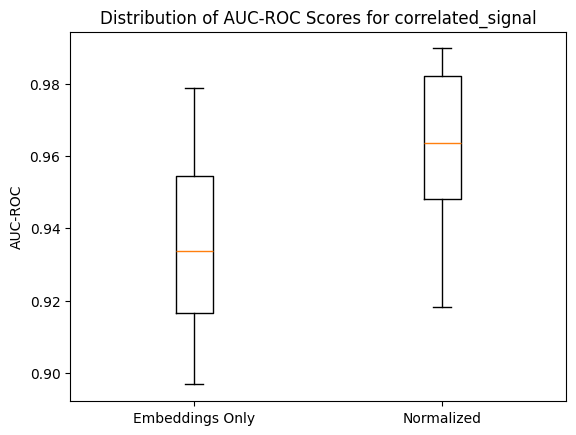

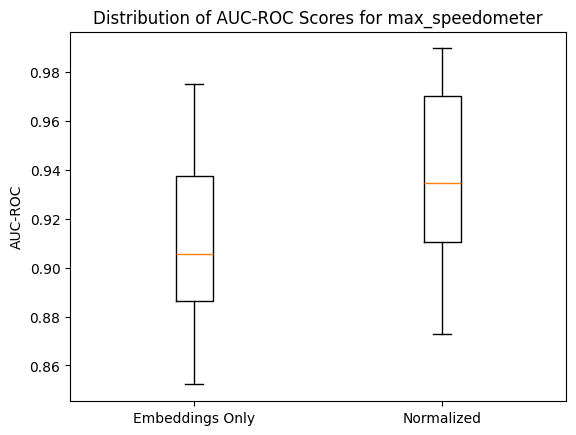

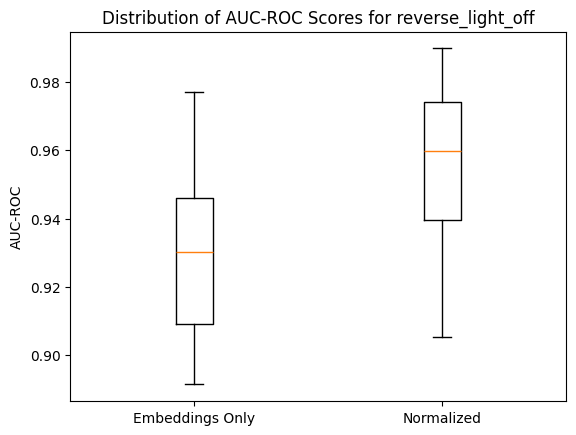

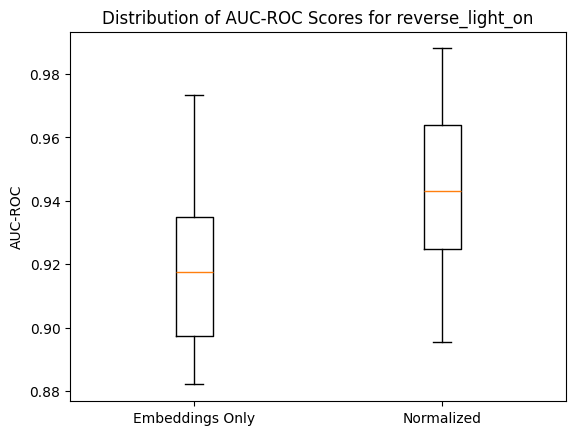

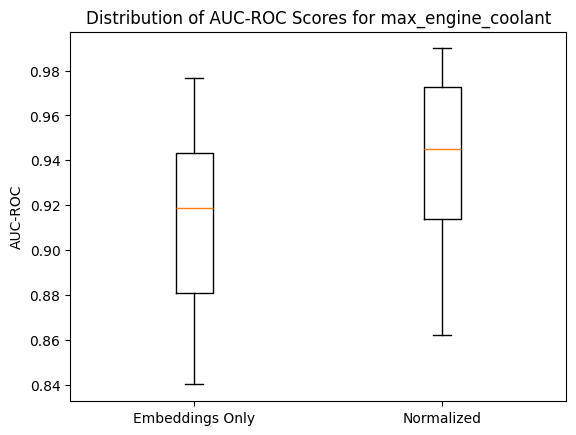

In [24]:
import matplotlib.pyplot as plt

for attack_type, df in all_data.items():
    embeddings_only = df[df['version'] == 'embeddings_only']['roc_auc']
    normalized = df[df['version'] == 'normalized']['roc_auc']
    
    plt.figure()
    plt.boxplot([embeddings_only, normalized], labels=['Embeddings Only', 'Normalized'])#normalized is embeddings combined with time series
    plt.title(f'Distribution of AUC-ROC Scores for {attack_type}')
    plt.ylabel('AUC-ROC')
    plt.show()


In [25]:
#Cohen's d effct size test
import numpy as np

# Function to calculate Cohen's d
def cohen_d(x, y):
    mean_diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.std(x, ddof=1)**2 + np.std(y, ddof=1)**2) / 2)
    return mean_diff / pooled_std

# Calculate descriptive statistics and Cohen's d for each attack type
for attack_type, df in all_data.items():
    embeddings_only = df[df['version'] == 'embeddings_only']['roc_auc']
    normalized = df[df['version'] == 'normalized']['roc_auc']
    
    # Descriptive statistics
    mean_embeddings_only = np.mean(embeddings_only)
    median_embeddings_only = np.median(embeddings_only)
    std_embeddings_only = np.std(embeddings_only, ddof=1)
    
    mean_normalized = np.mean(normalized)
    median_normalized = np.median(normalized)
    std_normalized = np.std(normalized, ddof=1)
    
    # Effect size
    effect_size = cohen_d(embeddings_only, normalized)
    
    print(f"Descriptive statistics for '{attack_type}' attack type:")
    print(f"  Embeddings Only: Mean={mean_embeddings_only:.4f}, Median={median_embeddings_only:.4f}, Std={std_embeddings_only:.4f}")
    print(f"  Normalized: Mean={mean_normalized:.4f}, Median={median_normalized:.4f}, Std={std_normalized:.4f}")
    print(f"  Effect size (Cohen's d): {effect_size:.4f}\n")


Descriptive statistics for 'correlated_signal' attack type:
  Embeddings Only: Mean=0.9354, Median=0.9337, Std=0.0238
  Normalized: Mean=0.9624, Median=0.9635, Std=0.0192
  Effect size (Cohen's d): -1.2486

Descriptive statistics for 'max_speedometer' attack type:
  Embeddings Only: Mean=0.9108, Median=0.9056, Std=0.0331
  Normalized: Mean=0.9379, Median=0.9345, Std=0.0330
  Effect size (Cohen's d): -0.8201

Descriptive statistics for 'reverse_light_off' attack type:
  Embeddings Only: Mean=0.9297, Median=0.9303, Std=0.0241
  Normalized: Mean=0.9556, Median=0.9599, Std=0.0226
  Effect size (Cohen's d): -1.1076

Descriptive statistics for 'reverse_light_on' attack type:
  Embeddings Only: Mean=0.9188, Median=0.9174, Std=0.0251
  Normalized: Mean=0.9447, Median=0.9431, Std=0.0251
  Effect size (Cohen's d): -1.0314

Descriptive statistics for 'max_engine_coolant' attack type:
  Embeddings Only: Mean=0.9130, Median=0.9187, Std=0.0388
  Normalized: Mean=0.9405, Median=0.9450, Std=0.0374
  E

In [ ]:
from scipy.stats import mannwhitneyu, ks_2samp

# Initialize dictionaries to store the test results
mannwhitneyu_results = {}
ks_results = {}

# Perform the tests for each attack type
for attack_type, df in all_data.items():
    embeddings_only = df[df['version'] == 'embeddings_only']['roc_auc']
    normalized = df[df['version'] == 'normalized']['roc_auc']
    
    # Mann-Whitney U test
    u_statistic, p_value_u = mannwhitneyu(normalized, embeddings_only, alternative='greater')
    mannwhitneyu_results[attack_type] = {'U Statistic': u_statistic, 'P Value': p_value_u}
    
    # One-sided Kolmogorov-Smirnov test with alternative='greater'
    ks_statistic, p_value_ks = ks_2samp(normalized, embeddings_only, alternative='greater')
    ks_results[attack_type] = {'KS Statistic': ks_statistic, 'P Value': p_value_ks}

# Print the results
for attack_type in mannwhitneyu_results:
    print(f"\nResults for '{attack_type}' attack type:")
    print(f"Mann-Whitney U Test - U Statistic: {mannwhitneyu_results[attack_type]['U Statistic']}, P Value: {mannwhitneyu_results[attack_type]['P Value']}")
    print(f"One-sided Kolmogorov-Smirnov Test - KS Statistic: {ks_results[attack_type]['KS Statistic']}, P Value: {ks_results[attack_type]['P Value']}")
